In [1]:
import json
import matplotlib.pylab as plt
import os
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

In [116]:
def calculate_f1(y_gold, y_model):
    """
    Computes the F1 of the model predictions using the
    gold labels. Each of y_gold and y_model are lists with
    labels 1 or -1. The function should return the F1
    score as a number between 0 and 1.
    """
    numerator = 0.0
    actual_entity = 0.0
    predicted_entity = 0.0
    for i in range(len(y_model)):
        if y_gold[i] == 1 and y_model[i] == 1:
            numerator += 1
        if y_model[i] == 1:
            predicted_entity += 1
        if y_gold[i] == 1:
            actual_entity += 1
            
    precision = numerator / predicted_entity
    recall = numerator / actual_entity
    
    f1 = (2 * precision * recall)/(precision + recall)
        
    return f1

In [56]:
class Classifier(object):
    """
    The Classifier class is the base class for all of the Perceptron-based
    algorithms. Your class should override the "process_example" and
    "predict_single" functions. Further, the averaged models should
    override the "finalize" method, where the final parameter values
    should be calculated. You should not need to edit this class any further.
    """
    def train(self, X, y):
        iterations = 10
        for iteration in range(iterations):
            for x_i, y_i in zip(X, y):
                self.process_example(x_i, y_i)
        self.finalize()

    def process_example(self, x, y):
        """
        Makes a predicting using the current parameter values for
        the features x and potentially updates the parameters based
        on the gradient. "x" is a dictionary which maps from the feature
        name to the feature value and y is either 1 or -1.
        """
        raise NotImplementedError

    def finalize(self):
        """Calculates the final parameter values for the averaged models."""
        pass

    def predict(self, X):
        """
        Predicts labels for all of the input examples. You should not need
        to override this method.
        """
        y = []
        for x in X:
            y.append(self.predict_single(x))
        return y

    def predict_single(self, x):
        """
        Predicts a label, 1 or -1, for the input example. "x" is a dictionary
        which maps from the feature name to the feature value.
        """
        raise NotImplementedError

In [57]:
class Perceptron(Classifier):
    def __init__(self, features):
        """
        Initializes the parameters for the Perceptron model. "features"
        is a list of all of the features of the model where each is
        represented by a string.
        """
        # Do not change the names of these 3 data members because
        # they are used in the unit tests
        self.eta = 1
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0

    def process_example(self, x, y):
        y_pred = self.predict_single(x)
        if y != y_pred:
            for feature, value in x.items():
                self.w[feature] += self.eta * y * value
            self.theta += self.eta * y

    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1

For the rest of the Perceptron-based algorithms, you will have to implement the corresponding class like we have done for "Perceptron".
Use the "Perceptron" class as a guide for how to implement the functions.

In [174]:
class AveragedPerceptron(Classifier):
    def __init__(self, features):
        self.eta = 1
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
      
        # You will need to add data members here
        self.m = {feature: 0.0 for feature in features}
        self.weightedW = {feature: 0.0 for feature in features}
        self.WeightedTheta = 0
        self.M = 0.00001
        self.k = 0
        self.c = 0  #number of correct examples
        
    def process_example(self, x, y):
        y_pred = self.predict_single(x)
        if y == y_pred:
             self.c += 1        
        else:
            self.m[self.k] = self.c
            self.M += self.m[self.k]           
            self.c = 1  #reset c
            for feature, value in x.items():
                self.w[feature] += self.eta * y * value 
                self.weightedW[feature] += self.eta * y * value*self.m[self.k]          
            self.theta += self.eta * y
            self.WeightedTheta += self.eta * y * self.m[self.k]          
            self.k += 1
                      
    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        for feature,value in self.w.items():    
            self.w[feature] -= (self.weightedW[feature]/self.M)
        self.theta -= (self.WeightedTheta/self.M) 
            
         

In [160]:
import math
class Winnow(Classifier):
    def __init__(self, alpha, features):
        # Do not change the names of these 3 data members because
        # they are used in the unit tests
        self.alpha = alpha
        self.w = {feature: 1.0 for feature in features}
        self.theta = -len(features)
        
    def process_example(self, x, y):
        y_pred = self.predict_single(x)
        if y != y_pred:
            for feature, value in x.items():
                self.w[feature] = self.w[feature] * math.pow(self.alpha, y*value)
                
    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1

In [167]:
class AveragedWinnow(Classifier):
    def __init__(self, alpha, features):
        self.alpha = alpha
        self.w = {feature: 1.0 for feature in features}
        self.theta = -len(features)
        # You will need to add data members here
        self.m = {feature: 0.0 for feature in features}
        self.weightedW = {feature: 0.0 for feature in features}
        self.WeightedTheta = 0
        self.M = 0.00001
        self.k = 0
        self.c = 0  #number of correct examples
        
    def process_example(self, x, y):
        y_pred = self.predict_single(x)
        if y == y_pred:
             self.c += 1        
        else:
            self.m[self.k] = self.c
            self.M += self.m[self.k]           
            self.c = 1  #reset c
            for feature, value in x.items():
                self.weightedW[feature] += ((self.w[feature] * math.pow(self.alpha, y*value)) - self.w[feature]) * self.m[self.k]
                self.w[feature] = self.w[feature] * math.pow(self.alpha, y*value)
            self.k += 1
                
    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        for feature,value in self.w.items():    
            self.w[feature] -= (self.weightedW[feature]/self.M)
        self.theta -= (self.WeightedTheta/self.M)

In [168]:
import math
class AdaGrad(Classifier):
    def __init__(self, eta, features):
        # Do not change the names of these 3 data members because
        # they are used in the unit tests
        self.eta = eta
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        self.G = {feature: 1e-5 for feature in features}  # 1e-5 prevents divide by 0 problems
        self.H = 0
        
    def process_example(self, x, y):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score * y <= 1:
            gradTheta = -y
            gradw = {feature: -y * value for feature,value in x.items()}
            for feature, value in x.items():
                self.G[feature] += math.pow(gradw[feature], 2) 
                self.w[feature] += self.eta * ((y * value) / math.sqrt(self.G[feature]))
            self.H += math.pow(gradTheta, 2)
            self.theta += self.eta * (y / math.sqrt(self.H))
            
    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1

In [169]:
class AveragedAdaGrad(Classifier):
    def __init__(self, eta, features):
        self.eta = eta
        self.w = {feature: 0.0 for feature in features}
        self.theta = 0
        self.G = {feature: 1e-5 for feature in features}
        self.H = 0
        # You will need to add data members here
        self.m = {feature: 0.0 for feature in features}
        self.weightedW = {feature: 0.0 for feature in features}
        self.WeightedTheta = 0
        self.M = 0.00001
        self.k = 1
        self.c = 0  #number of correct examples
        
    def process_example(self, x, y):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score * y <= 1:
            self.m[self.k] = self.c
            self.M += self.m[self.k]           
            self.c = 1  #reset c
            gradTheta = -y
            gradw = {feature: -y * value for feature,value in x.items()}
            for feature, value in x.items():
                self.G[feature] += math.pow(gradw[feature], 2) 
                self.w[feature] += self.eta * ((y * value) / math.sqrt(self.G[feature]))
                self.weightedW[feature] += self.eta * ((y * value) / math.sqrt(self.G[feature]))*self.m[self.k]  
            self.H += math.pow(gradTheta, 2)
            self.theta += self.eta * (y / math.sqrt(self.H))
            self.WeightedTheta += self.eta * (y / math.sqrt(self.H)) * self.m[self.k]          
            self.k += 1
        else:
            self.c += 1
            

    def predict_single(self, x):
        score = 0
        for feature, value in x.items():
            score += self.w[feature] * value
        score += self.theta
        if score <= 0:
            return -1
        return 1
        
    def finalize(self):
        for feature,value in self.w.items():    
            self.w[feature] -= (self.weightedW[feature]/self.M)
        self.theta -= (self.WeightedTheta/self.M)

In [63]:
def plot_learning_curves(perceptron_accs,
                         winnow_accs,
                         adagrad_accs,
                         avg_perceptron_accs,
                         avg_winnow_accs,
                         avg_adagrad_accs,
                         svm_accs):
    """
    This function will plot the learning curve for the 7 different models.
    Pass the accuracies as lists of length 11 where each item corresponds
    to a point on the learning curve.
    """
    assert len(perceptron_accs) == 11
    assert len(winnow_accs) == 11
    assert len(adagrad_accs) == 11
    assert len(avg_perceptron_accs) == 11
    assert len(avg_winnow_accs) == 11
    assert len(avg_adagrad_accs) == 11
    assert len(svm_accs) == 11

    x = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 50000]
    plt.figure()
    f, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
    ax.plot(x, perceptron_accs, label='perceptron')
    ax2.plot(x, perceptron_accs, label='perceptron')
    ax.plot(x, winnow_accs, label='winnow')
    ax2.plot(x, winnow_accs, label='winnow')
    ax.plot(x, adagrad_accs, label='adagrad')
    ax2.plot(x, adagrad_accs, label='adagrad')
    ax.plot(x, avg_perceptron_accs, label='avg-perceptron')
    ax2.plot(x, avg_perceptron_accs, label='avg-perceptron')
    ax.plot(x, avg_winnow_accs, label='avg-winnow')
    ax2.plot(x, avg_winnow_accs, label='avg-winnow')
    ax.plot(x, avg_adagrad_accs, label='avg-adagrad')
    ax2.plot(x, avg_adagrad_accs, label='avg-adagrad')
    ax.plot(x, svm_accs, label='svm')
    ax2.plot(x, svm_accs, label='svm')
    ax.set_xlim(0, 5500)
    ax2.set_xlim(49500, 50000)
    ax2.set_xticks([50000])
    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax.tick_params(labelright='off')
    ax2.yaxis.tick_right()
    ax2.legend()

In [11]:
def load_synthetic_data(directory_path):
    """
    Loads a synthetic dataset from the dataset root (e.g. "synthetic/sparse").
    You should not need to edit this method.
    """
    def load_jsonl(file_path):
        data = []
        with open(file_path, 'r') as f:
            for line in f:
                data.append(json.loads(line))
        return data

    def load_txt(file_path):
        data = []
        with open(file_path, 'r') as f:
            for line in f:
                data.append(int(line.strip()))
        return data

    def convert_to_sparse(X):
        sparse = []
        for x in X:
            data = {}
            for i, value in enumerate(x):
                if value != 0:
                    data[str(i)] = value
            sparse.append(data)
        return sparse

    X_train = load_jsonl(directory_path + '/train.X')
    X_dev = load_jsonl(directory_path + '/dev.X')
    X_test = load_jsonl(directory_path + '/test.X')

    num_features = len(X_train[0])
    features = [str(i) for i in range(num_features)]

    X_train = convert_to_sparse(X_train)
    X_dev = convert_to_sparse(X_dev)
    X_test = convert_to_sparse(X_test)

    y_train = load_txt(directory_path + '/train.y')
    y_dev = load_txt(directory_path + '/dev.y')
    y_test = load_txt(directory_path +  '/test.y')

    return X_train, y_train, X_dev, y_dev, X_test, y_test, features

In [166]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
def run_synthetic_experiment(data_path):
    """
    Runs the synthetic experiment on either the sparse or dense data
    depending on the data path (e.g. "data/sparse" or "data/dense").
    
    We have provided how to train the Perceptron on the training and
    test on the testing data (the last part of the experiment). You need
    to implement the hyperparameter sweep, the learning curves, and
    predicting on the test dataset for the other models.
    """
    X_train, y_train, X_dev, y_dev, X_test, y_test, features \
        = load_synthetic_data(data_path)
  
    #HyperParameter Sweep:
    winnow_hyper = [1.1, 1.01, 1.005, 1.0005, 1.0001]
    adagrad_hyper = [1.5, 0.25, 0.03, 0.005, 0.001]
    
    #Adagrad
    for rate in adagrad_hyper:
        classifier = AdaGrad(rate, features)
        Avgclassifier = AveragedAdaGrad(rate, features)
        classifier.train(X_train, y_train) #10 iterations
        Avgclassifier.train(X_train, y_train)
        y_pred = classifier.predict(X_test)
        Avg_y_pred = Avgclassifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        Avgacc = accuracy_score(y_test, Avg_y_pred)
        print('Adagrad : ', rate,' ',acc)
        print('AveragedAdagrad : ', rate,' ',Avgacc)
        
    #Winnow:
    for alpha in winnow_hyper:
        classifier = Winnow(alpha, features)
        Avgclassifier = AveragedWinnow(alpha, features)
        classifier.train(X_train, y_train) #10 iterations
        Avgclassifier.train(X_train, y_train)
        y_pred = classifier.predict(X_test)
        Avg_y_pred = Avgclassifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        Avgacc = accuracy_score(y_test, Avg_y_pred)
        print('Winnow : ', alpha, acc)
        print('AveragedWinnow : ', alpha, Avgacc)
     
    # TODO: Placeholder data for the learning curves. You should write
    # the logic to downsample the dataset to the number of desired training
    # instances (e.g. 500, 1000), then train all of the models on the
    # sampled dataset. Compute the accuracy and add the accuraices to
    # the corresponding list. 
    perceptron_accs = [0.1] * 11
    winnow_accs = [0.2] * 11
    adagrad_accs = [0.3] * 11
    avg_perceptron_accs = [0.4] * 11
    avg_winnow_accs = [0.5] * 11
    avg_adagrad_accs = [0.6] * 11
    svm_accs = [0.7] * 11
    
    #Learning Curve
    index = 500
    for i in range(11):      
        #Initialize
        if(i == 10):  #11th iteration, use all examples
            x_trainsplit = X_train
            y_trainsplit = y_train
        else:
            x_trainsplit = X_train[:index]
            y_trainsplit = y_train[:index]
        per_classifier = Perceptron(features)
        win_classifier = Winnow(1.005,features)
        ada_classifier = AdaGrad(1.5,features)
        avg_per_classifier = AveragedPerceptron(features)
        avg_win_classifier = AveragedWinnow(1.1,features)
        avg_ada_classifier = AveragedAdaGrad(1.5,features)
        svc_classifier = LinearSVC(loss='hinge')
        
        #train
        v = DictVectorizer()
        x_train_vect = v.fit_transform(x_trainsplit)
        x_dev_vect = v.fit_transform(X_dev)  
        svc_classifier.fit(x_train_vect, y_trainsplit)
        per_classifier.train(x_trainsplit, y_trainsplit)
        win_classifier.train(x_trainsplit, y_trainsplit)
        ada_classifier.train(x_trainsplit, y_trainsplit)
        avg_per_classifier.train(x_trainsplit, y_trainsplit)
        avg_win_classifier.train(x_trainsplit, y_trainsplit)
        avg_ada_classifier.train(x_trainsplit, y_trainsplit)
        
        #predict and evaluate
        per_y_pred = per_classifier.predict(X_dev)
        win_y_pred = win_classifier.predict(X_dev)
        ada_y_pred = ada_classifier.predict(X_dev)
        avg_per_y_pred = avg_per_classifier.predict(X_dev)
        avg_win_y_pred = avg_win_classifier.predict(X_dev)
        avg_ada_y_pred = avg_ada_classifier.predict(X_dev)
        svc_y_pred = svc_classifier.predict(x_dev_vect)
        
        #Accuracy
        per_acc = accuracy_score(y_dev, per_y_pred)
        win_acc = accuracy_score(y_dev, win_y_pred)
        ada_acc = accuracy_score(y_dev, ada_y_pred)
        avg_per_acc = accuracy_score(y_dev, avg_per_y_pred)
        avg_win_acc = accuracy_score(y_dev, avg_win_y_pred)
        avg_ada_acc = accuracy_score(y_dev, avg_ada_y_pred)
        svm_acc = accuracy_score(y_dev, svc_y_pred)
        
        perceptron_accs[i] = per_acc
        winnow_accs[i] = win_acc
        adagrad_accs[i] = ada_acc
        avg_perceptron_accs[i] = avg_per_acc
        avg_winnow_accs[i] = avg_win_acc
        avg_adagrad_accs[i] = avg_ada_acc
        svm_accs[i] = svm_acc
       
        index += 500
                                            
    plot_learning_curves(perceptron_accs, winnow_accs, adagrad_accs, avg_perceptron_accs, avg_winnow_accs, avg_adagrad_accs, svm_accs)
    
    #Final Evaluation:
    per_classifier = Perceptron(features)
    win_classifier = Winnow(1.005,features)
    ada_classifier = AdaGrad(1.5,features)
    avg_per_classifier = AveragedPerceptron(features)
    avg_win_classifier = AveragedWinnow(1.005,features)
    avg_ada_classifier = AveragedAdaGrad(1.5,features)
    svc_classifier = LinearSVC(loss='hinge')
        
    #train
    v = DictVectorizer()
    x_train_vect = v.fit_transform(X_train)
    x_test_vect = v.fit_transform(X_test)  
    svc_classifier.fit(x_train_vect, y_train)
    per_classifier.train(X_train, y_train)
    win_classifier.train(X_train, y_train)
    ada_classifier.train(X_train, y_train)
    avg_per_classifier.train(X_train, y_train)
    avg_win_classifier.train(X_train, y_train)
    avg_ada_classifier.train(X_train, y_train)
        
    #predict and evaluate
    per_y_pred = per_classifier.predict(X_test)
    win_y_pred = win_classifier.predict(X_test)
    ada_y_pred = ada_classifier.predict(X_test)
    avg_per_y_pred = avg_per_classifier.predict(X_test)
    avg_win_y_pred = avg_win_classifier.predict(X_test)
    avg_ada_y_pred = avg_ada_classifier.predict(X_test)
    svc_y_pred = svc_classifier.predict(x_test_vect)
        
    #Accuracy
    per_acc = accuracy_score(y_test, per_y_pred)
    win_acc = accuracy_score(y_test, win_y_pred)
    ada_acc = accuracy_score(y_test, ada_y_pred)
    avg_per_acc = accuracy_score(y_test, avg_per_y_pred)
    avg_win_acc = accuracy_score(y_test, avg_win_y_pred)
    avg_ada_acc = accuracy_score(y_test, avg_ada_y_pred)
    svm_acc = accuracy_score(y_test, svc_y_pred)
    
    print("Perceptron Accuracy", per_acc)
    print("Winnow Accuracy", win_acc)
    print("Adagrad Accuracy", ada_acc)
    print("Average Perceptron Accuracy", avg_per_acc)
    print("Average Winnow Accuracy", avg_win_acc)
    print("Average Adagrad Accuracy", avg_ada_acc)
    print("SVM Accuracy", svm_acc)
                    

Winnow 0.92
Averaged Winnow 0.9196
Adagrad :  1.5   0.9433
AveragedAdagrad :  1.5   0.9433
Adagrad :  0.25   0.9004
AveragedAdagrad :  0.25   0.9004
Adagrad :  0.03   0.7332
AveragedAdagrad :  0.03   0.7332
Adagrad :  0.005   0.5034
AveragedAdagrad :  0.005   0.5034
Adagrad :  0.001   0.4988
AveragedAdagrad :  0.001   0.4988
Winnow :  1.1 0.92
AveragedWinnow :  1.1 0.9196
Winnow :  1.01 0.9294
AveragedWinnow :  1.01 0.9294
Winnow :  1.005 0.9337
AveragedWinnow :  1.005 0.9337
Winnow :  1.0005 0.9146
AveragedWinnow :  1.0005 0.9146
Winnow :  1.0001 0.5761
AveragedWinnow :  1.0001 0.5761
Perceptron Accuracy 0.8277
Winnow Accuracy 0.9337
Adagrad Accuracy 0.9433
Average Perceptron Accuracy 0.8248
Average Winnow Accuracy 0.9337
Average Adagrad Accuracy 0.9433
SVM Accuracy 0.9433


<Figure size 432x288 with 0 Axes>

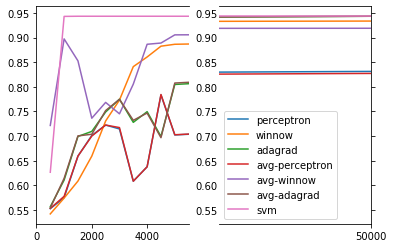

In [170]:
run_synthetic_experiment("synthetic/sparse")

Winnow 0.9028
Averaged Winnow 0.9027
Adagrad :  1.5   0.9372
AveragedAdagrad :  1.5   0.9372
Adagrad :  0.25   0.9372
AveragedAdagrad :  0.25   0.9372
Adagrad :  0.03   0.6217
AveragedAdagrad :  0.03   0.6217
Adagrad :  0.005   0.4971
AveragedAdagrad :  0.005   0.4971
Adagrad :  0.001   0.4971
AveragedAdagrad :  0.001   0.4971
Winnow :  1.1 0.9028
AveragedWinnow :  1.1 0.9027
Winnow :  1.01 0.9338
AveragedWinnow :  1.01 0.9338
Winnow :  1.005 0.9317
AveragedWinnow :  1.005 0.9316
Winnow :  1.0005 0.9304
AveragedWinnow :  1.0005 0.9304
Winnow :  1.0001 0.8346
AveragedWinnow :  1.0001 0.8346
Perceptron Accuracy 0.9193
Winnow Accuracy 0.9317
Adagrad Accuracy 0.9372
Average Perceptron Accuracy 0.9212
Average Winnow Accuracy 0.9316
Average Adagrad Accuracy 0.9372
SVM Accuracy 0.9372


<Figure size 432x288 with 0 Axes>

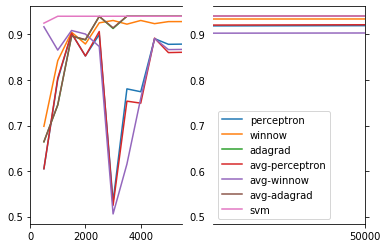

In [171]:
run_synthetic_experiment("synthetic/dense")

In [107]:
def load_ner_data(path):
    """
    Loads the NER data from a path (e.g. "ner/conll/train"). You should
    not need to edit this method.
    """
    # List of tuples for each sentence
    data = []
    for filename in os.listdir(path):
        with open(path + '/' + filename, 'r') as file:
            sentence = []
            for line in file:
                if line == '\n':
                    data.append(sentence)
                    sentence = []
                else:
                    sentence.append(tuple(line.split()))
    return data

In [102]:
def extract_ner_features_train(train):
    """
    Extracts feature dictionaries and labels from the data in "train"
    Additionally creates a list of all of the features which were created.
    We have implemented the w-1 and w+1 features for you to show you how
    to create them.
    
    """
    y = []
    X = []
    features = set()
    for sentence in train:
        padded = sentence[:]
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        for i in range(3, len(padded) - 3):
            y.append(1 if padded[i][1] == 'I' else -1)
            feat1 = 'w-1=' + str(padded[i - 1][0])
            feat2 = 'w+1=' + str(padded[i + 1][0])
            feat3 = 'w-2=' + str(padded[i - 2][0])
            feat4 = 'w+2=' + str(padded[i + 2][0])
            feat5 = 'w-3=' + str(padded[i - 3][0])
            feat6 = 'w+3=' + str(padded[i + 3][0])
            feat7 = feat1 + '&' + feat2
            feat8 = feat2 + '&' + feat4
            feat9 = feat1 + '&' + feat3
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            features.update(feats)
            feats = {feature: 1 for feature in feats}
            X.append(feats)
    return features, X, y

In [88]:
X = ['FORDO', 'FORDOLODO', 'A', 'B']
padded = X[:]
print(X)
padded.insert(0, ('SSS', None))
padded.insert(0, ('SSS', None))
print(padded)
print(padded[0][0])
print(padded[0][1])
print(padded[1][1])
print(padded[2][3])

['FORDO', 'FORDOLODO', 'A', 'B']
[('SSS', None), ('SSS', None), 'FORDO', 'FORDOLODO', 'A', 'B']
SSS
None
None
D


In [103]:
def extract_features_dev_or_test(data, features):
    """
    Extracts feature dictionaries and labels from "data". The only
    features which should be computed are those in "features". You
    should add your additional featurization code here.
    """
    y = []
    X = []
    for sentence in data:
        padded = sentence[:]
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.insert(0, ('SSS', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        padded.append(('EEE', None))
        for i in range(3, len(padded) - 3):
            y.append(1 if padded[i][1] == 'I' else -1)
            feat1 = 'w-1=' + str(padded[i - 1][0])
            feat2 = 'w+1=' + str(padded[i + 1][0])
            feat3 = 'w-2=' + str(padded[i - 2][0])
            feat4 = 'w+2=' + str(padded[i + 2][0])
            feat5 = 'w-3=' + str(padded[i - 3][0])
            feat6 = 'w+3=' + str(padded[i + 3][0])
            feat7 = feat1 + '&' + feat2
            feat8 = feat2 + '&' + feat4
            feat9 = feat1 + '&' + feat3
            feats = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]
            feats = {feature: 1 for feature in feats if feature in features}
            X.append(feats)
    return X, y

In [175]:
def run_ner_experiment(data_path):
    """
    Runs the NER experiment using the path to the ner data
    (e.g. "ner" from the released resources). We have implemented
    the standard Perceptron below. You should do the same for
    the averaged version and the SVM.
    
    The SVM requires transforming the features into a different
    format. See the end of this function for how to do that.
    """
    train = load_ner_data(data_path + '/conll/train')
    conll_test = load_ner_data(data_path + '/conll/test')
    enron_test = load_ner_data(data_path + '/enron/test')

    features, X_train, y_train = extract_ner_features_train(train)
    X_conll_test, y_conll_test = extract_features_dev_or_test(conll_test, features)
    X_enron_test, y_enron_test = extract_features_dev_or_test(enron_test, features)
                 
    # You should do this for the Averaged Perceptron and SVM
    classifier = AveragedPerceptron(features)
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_conll_test)
    conll_f1 = calculate_f1(y_conll_test, y_pred)
    y_pred = classifier.predict(X_enron_test)
    enron_f1 = calculate_f1(y_enron_test, y_pred)
    print('Averaged Perceptron')
    print('  CoNLL', conll_f1)
    print('  Enron', enron_f1)
    
    # This is how you convert from the way we represent features in the
    # Perceptron code to how you need to represent features for the SVM.
    # You can then train with (X_train_dict, y_train) and test with
    # (X_conll_test_dict, y_conll_test) and (X_enron_test_dict, y_enron_test)
    vectorizer = DictVectorizer()
    X_train_dict = vectorizer.fit_transform(X_train)
    X_conll_test_dict = vectorizer.transform(X_conll_test)
    X_enron_test_dict = vectorizer.transform(X_enron_test)
    
    classifier = LinearSVC(loss='hinge')
    classifier.fit(X_train_dict, y_train)
    y_pred = classifier.predict(X_conll_test_dict)
    conll_f1 = calculate_f1(y_conll_test, y_pred)
    y_pred = classifier.predict(X_enron_test_dict)
    enron_f1 = calculate_f1(y_enron_test, y_pred)
    print('SVC')
    print('  CoNLL', conll_f1)
    print('  Enron', enron_f1)
    

In [176]:
run_ner_experiment('ner')

Averaged Perceptron
  CoNLL 0.7931526390870186
  Enron 0.1741424802110818
SVC
  CoNLL 0.827823691460055
  Enron 0.24068157614483493


/Users/dan/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Perceptron 0.8277


<Figure size 432x288 with 0 Axes>

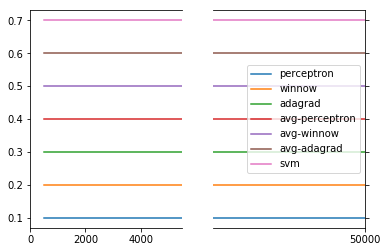

In [29]:
# Run the synthetic experiment on the sparse dataset. "synthetic/sparse"
# is the path to where the data is located.
run_synthetic_experiment('synthetic/sparse')

Perceptron 0.9193


<Figure size 432x288 with 0 Axes>

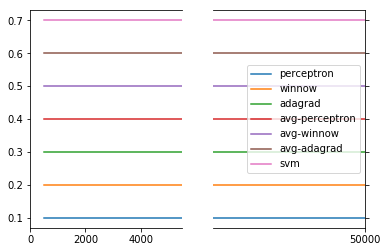

In [30]:
# Run the synthetic experiment on the sparse dataset. "synthetic/dense"
# is the path to where the data is located.
run_synthetic_experiment('synthetic/dense')

In [31]:
# Run the NER experiment. "ner" is the path to where the data is located.
run_ner_experiment('ner')

Averaged Perceptron
  CoNLL 0.0
  Enron 0.0
